## 模型构建的一般流程

### 前置包的导入

In [55]:
import tensorflow as tf
from tensorflow import keras
# 引用经典数据集时的 datasets，适用容器 Sequential, 网络层的父类 layers，网络的父类 Model,优化器 optimizers
# 损失类 loss
from tensorflow.keras import datasets, Sequential, layers,optimizers
import  datetime
import matplotlib.pyplot as plt
import io

### 数据预处理

In [56]:
#以图片数据为例，适用于全连接层
def preprocess(x, y):
    """
    自定义预处理函数
    参数：
    x -- 待处理的数据集,维度[b,28,28]
    y -- 待处理的数据集,[b]

    返回值：
    x -- 标准化和扁平化后的 x
    y -- 转换为 one_hot 向量
    """
    x = tf.cast(x, dtype=tf.float32) / 255. #标准化0-1
     #扁平化-不建议，后续需要用 squeeze函数处理。者此处不设，而在输入的时候对x设置x.reshape(x,(-1, 28*28))
    # x = tf.reshape(x, [-1, 28*28])

    y = tf.cast(y, dtype=tf.int32)
    y = tf.one_hot(y, depth=10)

    return x,y

### 数据集加载

拓展：可以考虑其他测试集进行，如 fashion_mnist,相比于 mnist 复杂

In [57]:
(x,y), (x_test, y_test)=datasets.mnist.load_data()
print('数据集mnist中x的维度', x.shape, '数据集mnist中y的维度', y.shape)
#数据加载后，需要转换为 Dataset对象
train_db = tf.data.Dataset.from_tensor_slices((x, y))
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# db = db.step1().step2().step3()
# shuffle(缓冲区大小，一般是一个较大的常数)，btach(一批的样本数量)
train_db = train_db.map(preprocess).shuffle(10000).batch(128)
test_db = test_db.map(preprocess).batch(128)

数据集mnist中x的维度 (60000, 28, 28) 数据集mnist中y的维度 (60000,)


In [58]:
# 数据维度查看
db_iter = iter(train_db)
sample = next(db_iter)
print('批样本 x 维度:', sample[0].shape,"批样本 y 维度", sample[1].shape)

批样本 x 维度: (128, 28, 28) 批样本 y 维度 (128, 10)


### 模型的构建

拓展：增加网络的层数，观察损失和准确率

In [59]:
model = keras.Sequential([ 
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)])
model.build(input_shape=[None, 28*28])
# 将网络结构显示出来
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


### 梯度下降和优化

均方误差函数

$$MSE(y, out)=\frac{1}{m} \sum_{i=1}^m (y_i - out_i)^2 $$

In [60]:
# 可视化操作
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = 'logs/' + current_time
# 用相关函数创建对象
summary_writer = tf.summary.create_file_writer(log_dir) 

# get x from (x,y)
sample_img = next(iter(train_db))[0]
# get first image instance
sample_img = sample_img[0]
sample_img = tf.reshape(sample_img, [1, 28, 28, 1])
with summary_writer.as_default():
    tf.summary.image("Training sample:", sample_img, step=0)

In [61]:
# 可视化要求的数据
def image_grid(images):
  """Return a 5x5 grid of the MNIST images as a matplotlib figure."""
  # Create a figure to contain the plot.
  figure = plt.figure(figsize=(10,10))
  for i in range(25):
    # Start next subplot.
    plt.subplot(5, 5, i + 1, title='name')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
  
  return figure

In [62]:
# 可视化要求的数据
def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

0 0 交叉熵损失函数 0.00681459903717041 均方误差函数 126.5805435180664
准确率为： 0.98


InvalidArgumentError: slice index 15 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

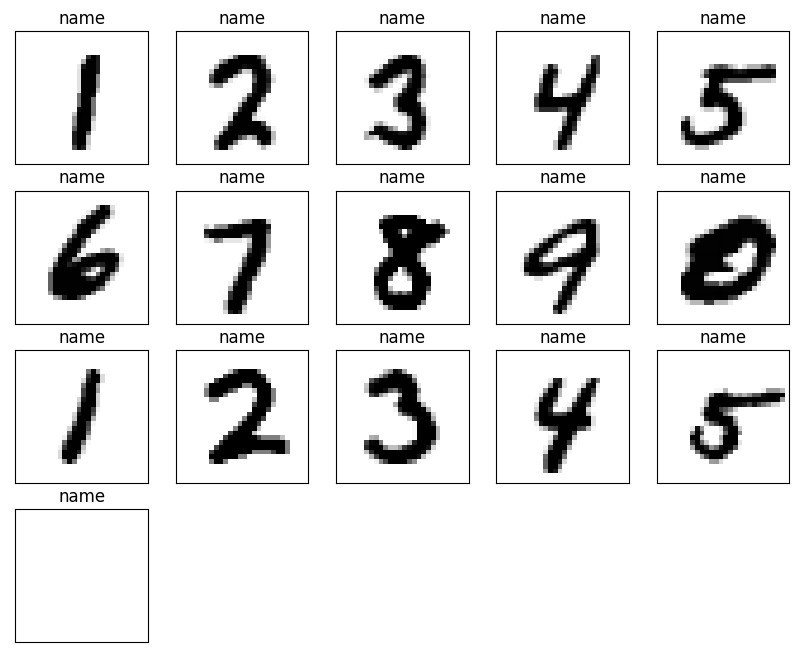

In [71]:
# optimizer = optimizers.SGD(learning_rate=0.001)
# 优化器设置,完成更新过程 w = w - lr * grad
optimizer = optimizers.Adam(learning_rate=0.001)
for epoch in range(30):
    for step, (x, y) in enumerate(train_db):
        x = tf.reshape(x, [-1, 28*28])
        with tf.GradientTape() as tape:
            # 前向传播，[b, 28*28] => [b, 10]
            out = model(x)
            # from_logits=True设置为True,表示未经过 softmax，不是 prob，而是具体的数值
            loss = tf.reduce_mean(tf.losses.categorical_crossentropy(y, out, from_logits=True))
            loss_mse = tf.reduce_mean(tf.losses.MSE(y, out))
        # 参数量集合 model.trainable_variables 包含 w1, b1, w2, b2...
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        if step % 500 == 0:
            print(epoch, step, '交叉熵损失函数', float(loss), "均方误差函数", float(loss_mse))
        
        # 可视化1
        if step % 100 == 0:
            with summary_writer.as_default(): 
                tf.summary.scalar('train-loss', float(loss), step=step) 
        
    
    # 测试集
    correct_num, total_correct, total_num = 0, 0, 0
    for x,y in test_db:
        # x:[b, 28, 28] => [b, 28*28]
        # y:[b]
        x = tf.reshape(x, [-1, 28*28])
        logits = model(x)
        # 先将 logits => prob 转换为概率,然后求出概率最大值所在的索引
        # [b] => [b, 10]
        prob = tf.nn.softmax(logits)
        # [b, 10] => [b],pred -- int64
        pred = tf.argmax(prob, axis=1)
        # print(pred) 
        y = tf.argmax(y, axis=1)
        # print(y)
        correct_num = tf.equal(pred, y)
        correct_num = tf.reduce_sum(tf.cast(correct_num, tf.int32)).numpy()
        # 不使用numpy时，采用int(correct_num)
        total_correct += correct_num

        total_num += x.shape[0]
    
    acc = total_correct / total_num
    print("准确率为：",acc)   
    
    val_images = x[:16]
    # print(val_images)
    val_images = tf.reshape(val_images, [-1, 28, 28, 1])
    # print(val_images)
    with summary_writer.as_default():
        tf.summary.scalar('test-acc', float(acc), step=step)
        # 零散的图片
        tf.summary.image("val-onebyone-images:", val_images, max_outputs=25, step=step)
            
        val_images = tf.reshape(val_images, [-1, 28, 28])
        # print(val_images)
        figure  = image_grid(val_images)
        # 拼接的图片
        tf.summary.image('val-images:', plot_to_image(figure), step=step)   
